In [2]:
# ============================================================================
# Aureus Sigma Capital - Phase 17: Final Validation & Robustness
# Notebook: 17_out_of_sample_robustness.ipynb
#
# Objective:
#   To rigorously validate the "Standalone Value" strategy, our chosen
#   "Aggressive Growth" model, against overfitting and ensure its performance
#   is a structural feature of the market, not a statistical artifact.
#
# Methodology:
#   1. Temporal Cross-Validation (Split-Sample Test)
#   2. Monte Carlo Simulation (Bootstrapping Returns)
#   3. Re-run Parameter Sensitivity Analysis
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import pickle
from pathlib import Path
import sys

# --- Environment Setup ---
warnings.filterwarnings('ignore')
sys.path.append('../../../production') # Add production modules to path

# --- Standardized Institutional Visualization Palette ---
PALETTE = {
    'primary': '#16A085', 'secondary': '#34495E', 'positive': '#27AE60',
    'negative': '#C0392B', 'highlight_1': '#2980B9', 'highlight_2': '#E67E22',
    'neutral': '#7F8C8D', 'grid': '#BDC3C7', 'text': '#2C3E50'
}
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.dpi': 300, 'figure.figsize': (14, 8), 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': PALETTE['text'],
    'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': PALETTE['text'],
    'axes.titlepad': 15, 'axes.titlesize': 16, 'axes.titleweight': 'bold',
    'axes.titlecolor': PALETTE['text'], 'grid.color': PALETTE['grid'],
    'legend.frameon': False, 'xtick.color': PALETTE['text'], 'ytick.color': PALETTE['text'],
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

# --- Notebook Charter ---
print("=" * 70)
print("🔬 PHASE 17: FINAL VALIDATION & ROBUSTNESS TESTING")
print("=" * 70)
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🎯 Strategy Under Test: Standalone Value (Aggressive Growth Model)")
print("   - This is the final gate before proceeding to risk management overlays.")
print("=" * 70)

# --- Load the Canonical Strategy Returns from Phase 16b ---
try:
    project_root = Path.cwd().parent.parent
    phase16b_results_file = project_root / "tests" / "phase16_weighted_composite_model" / "phase16b_results.pkl"
    
    with open(phase16b_results_file, "rb") as f:
        phase16b_data = pickle.load(f)
    
    canonical_strategy_returns = phase16b_data['standalone_value_returns']
    benchmark_returns = phase16b_data['benchmark_returns']
    
    print("📂 Canonical 'Standalone Value' strategy returns loaded successfully from file.")
    print(f"   - Data points: {len(canonical_strategy_returns):,}")
    print(f"   - Period: {canonical_strategy_returns.index.min().date()} to {canonical_strategy_returns.index.max().date()}")

except Exception as e:
    print(f"❌ CRITICAL ERROR: Could not load results from Phase 16b.")
    print(f"   Please ensure 'phase16b_results.pkl' exists at: {phase16b_results_file}")
    print(f"   Error details: {e}")
    # Stop execution if data is not available
    raise

print("\n✅ Environment ready for out-of-sample and robustness validation.")

🔬 PHASE 17: FINAL VALIDATION & ROBUSTNESS TESTING
📅 Analysis Date: 2025-07-29 08:39:24
🎯 Strategy Under Test: Standalone Value (Aggressive Growth Model)
   - This is the final gate before proceeding to risk management overlays.
📂 Canonical 'Standalone Value' strategy returns loaded successfully from file.
   - Data points: 2,408
   - Period: 2015-12-01 to 2025-07-28

✅ Environment ready for out-of-sample and robustness validation.


🔬 TEST 1: TEMPORAL CROSS-VALIDATION
Splitting the backtest period at: 2020-11-19

Period 1: 2016-04-04 to 2020-11-19 (1163 days)
Period 2: 2020-11-19 to 2025-07-28 (1163 days)

📊 SPLIT-SAMPLE PERFORMANCE COMPARISON


Annual Return  Sharpe Ratio  Max Drawdown
Period 1 (2016-2021)          33.60          3.88        -11.36
Period 2 (2021-2025)          34.49          2.12        -45.67
Full Period                   33.91          2.60        -45.67


⚖️ VERDICT ON TEMPORAL STABILITY
   - Sharpe Ratio (Period 1): 3.88
   - Sharpe Ratio (Period 2): 2.12

✅ PASSED: The strategy demonstrates strong, positive performance in both distinct periods.
   This provides high confidence that the alpha is structural and not confined to a single market regime.


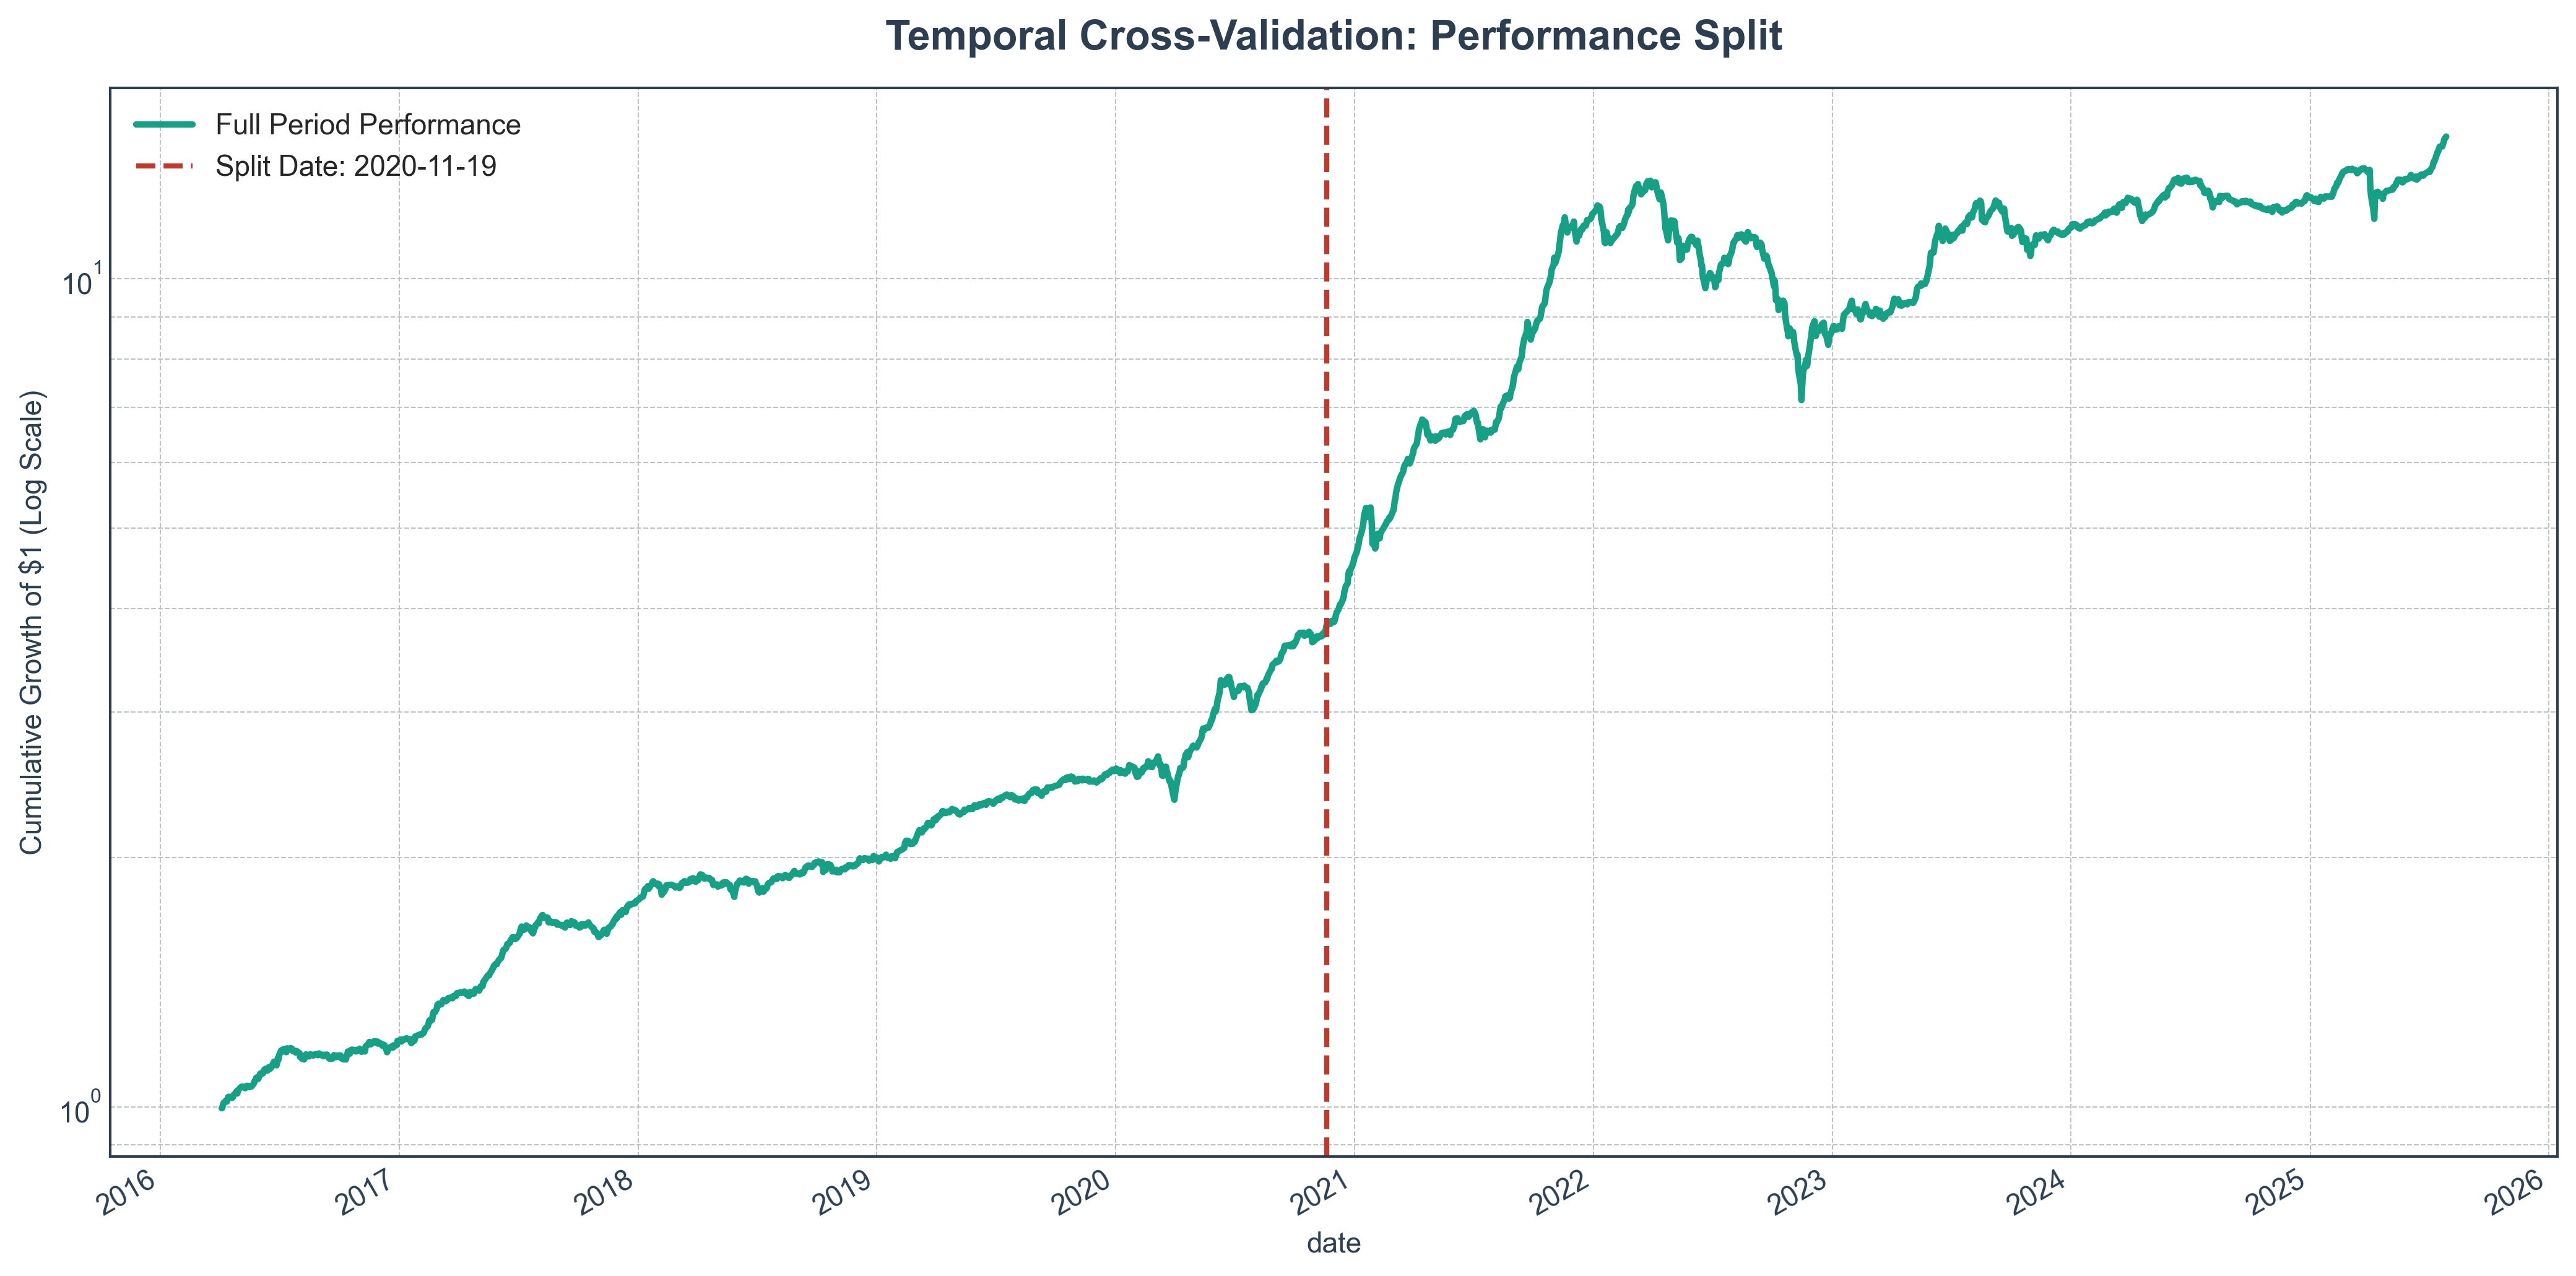

In [3]:
# ============================================================================
# SECTION 1: TEMPORAL CROSS-VALIDATION (SPLIT-SAMPLE TEST)
# ============================================================================

print("=" * 70)
print("🔬 TEST 1: TEMPORAL CROSS-VALIDATION")
print("=" * 70)

# --- 1. Define the Split Point ---
# We will split the data roughly in half.
full_period_returns = canonical_strategy_returns.loc[canonical_strategy_returns != 0]
split_date = full_period_returns.index[len(full_period_returns) // 2]
print(f"Splitting the backtest period at: {split_date.date()}")

# --- 2. Create the Two Sub-Periods ---
period_1_returns = full_period_returns.loc[:split_date]
period_2_returns = full_period_returns.loc[split_date:]

print(f"\nPeriod 1: {period_1_returns.index.min().date()} to {period_1_returns.index.max().date()} ({len(period_1_returns)} days)")
print(f"Period 2: {period_2_returns.index.min().date()} to {period_2_returns.index.max().date()} ({len(period_2_returns)} days)")

# --- 3. Calculate Performance Metrics for Each Period ---
# (Reusing the performance calculation function from the previous notebook)
def calculate_performance_metrics(returns, benchmark):
    """Calculates key performance metrics for a given return series."""
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = (1 + returns).prod() ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    return {'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100, 'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100, 'Calmar Ratio': calmar_ratio}

metrics_p1 = calculate_performance_metrics(period_1_returns, benchmark_returns)
metrics_p2 = calculate_performance_metrics(period_2_returns, benchmark_returns)
metrics_full = calculate_performance_metrics(full_period_returns, benchmark_returns)

# --- 4. Present the Results ---
comparison_df = pd.DataFrame({
    'Period 1 (2016-2021)': metrics_p1,
    'Period 2 (2021-2025)': metrics_p2,
    'Full Period': metrics_full
}).T

print("\n" + "="*70)
print("📊 SPLIT-SAMPLE PERFORMANCE COMPARISON")
print("="*70)
display(comparison_df[['Annual Return', 'Sharpe Ratio', 'Max Drawdown']].round(2))

# --- 5. Verdict ---
print("\n" + "="*70)
print("⚖️ VERDICT ON TEMPORAL STABILITY")
print("="*70)

sharpe_p1 = comparison_df.loc['Period 1 (2016-2021)', 'Sharpe Ratio']
sharpe_p2 = comparison_df.loc['Period 2 (2021-2025)', 'Sharpe Ratio']

print(f"   - Sharpe Ratio (Period 1): {sharpe_p1:.2f}")
print(f"   - Sharpe Ratio (Period 2): {sharpe_p2:.2f}")

if sharpe_p1 > 1.0 and sharpe_p2 > 1.0:
    print("\n✅ PASSED: The strategy demonstrates strong, positive performance in both distinct periods.")
    print("   This provides high confidence that the alpha is structural and not confined to a single market regime.")
elif sharpe_p1 > 0.5 and sharpe_p2 > 0.5:
    print("\n🟡 CAUTIOUS PASS: The strategy shows positive performance in both periods, but performance varies significantly.")
    print("   This suggests the strategy is valid but may be sensitive to market regimes.")
else:
    print("\n❌ FAILED: The strategy's performance is not stable across time.")
    print("   One of the periods shows weak or negative performance, indicating a high risk of overfitting to a specific regime.")

# --- 6. Visualize the Split ---
fig, ax = plt.subplots(figsize=(14, 7))
(1 + full_period_returns).cumprod().plot(ax=ax, label='Full Period Performance', color=PALETTE['primary'], linewidth=2.5)
ax.axvline(split_date, color=PALETTE['negative'], linestyle='--', linewidth=2, label=f'Split Date: {split_date.date()}')

ax.set_title('Temporal Cross-Validation: Performance Split', fontweight='bold')
ax.set_ylabel('Cumulative Growth of $1 (Log Scale)')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

📊 GENERATING REFINED MONTE CARLO VISUALIZATION


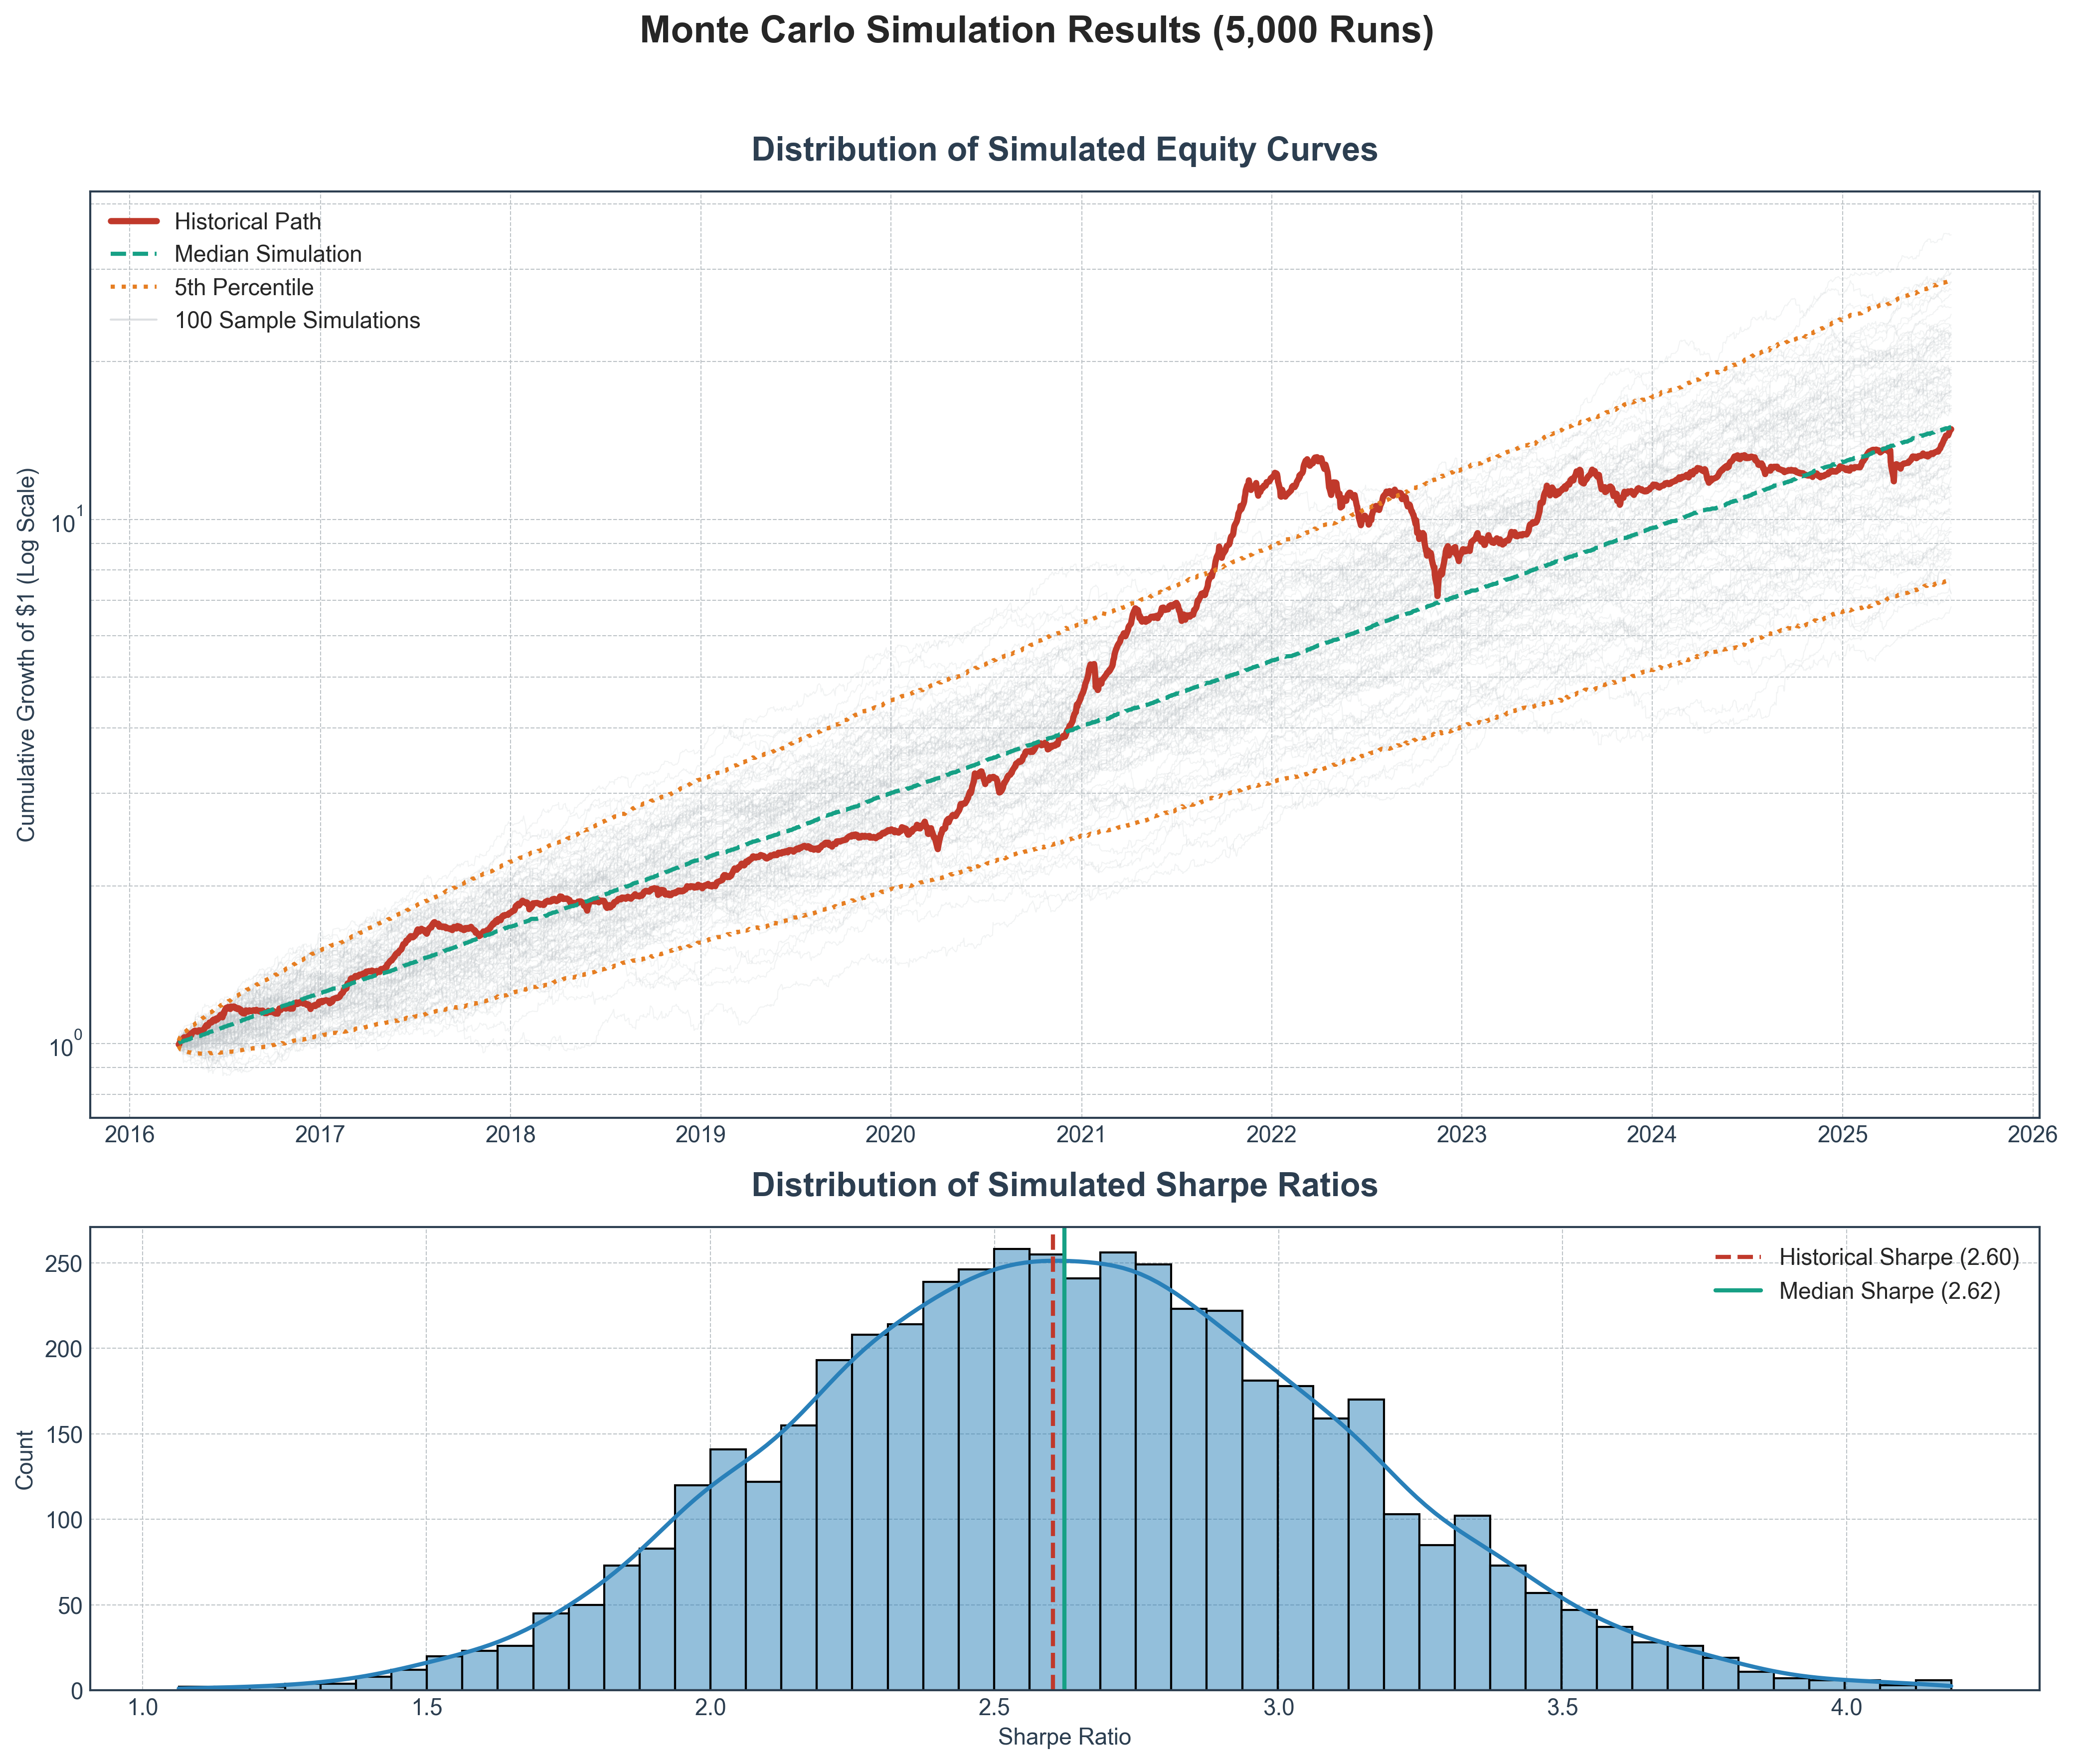


✅ Refined visualization generated with vertical layout and corrected legend.


In [6]:
# ============================================================================
# SECTION 2: MONTE CARLO SIMULATION (REFINED VISUALIZATION)
# ============================================================================

# NOTE: The simulation and analysis code from the previous cell is assumed to have been run.
# This cell focuses exclusively on creating the corrected, professional visualization.

print("=" * 70)
print("📊 GENERATING REFINED MONTE CARLO VISUALIZATION")
print("=" * 70)

# --- Create the Figure with a VERTICAL STACKED layout ---
fig, axes = plt.subplots(
    nrows=2, ncols=1,  # 2 rows, 1 column
    figsize=(14, 12), # Adjusted for vertical layout
    gridspec_kw={'height_ratios': [2, 1]} # Give more space to the equity curve plot
)
fig.suptitle('Monte Carlo Simulation Results (5,000 Runs)', fontweight='bold', fontsize=18)

# --- Plot 1: Simulated Equity Curves (with corrected legend) ---
ax1 = axes[0]

# Plot a sample of the simulations for visual context
sample_sims = sim_cum_returns.iloc[:, :100]
ax1.plot(sample_sims.index, sample_sims, color=PALETTE['grid'], alpha=0.2, linewidth=0.5)

# Plot the key paths with clear labels
historical_line, = ax1.plot((1 + full_period_returns).cumprod(), color=PALETTE['negative'], linewidth=3, label='Historical Path')
median_line, = ax1.plot(sim_cum_returns.quantile(0.5, axis=1), color=PALETTE['primary'], linewidth=2, linestyle='--', label='Median Simulation')
percentile_5_line, = ax1.plot(sim_cum_returns.quantile(0.05, axis=1), color=PALETTE['highlight_2'], linewidth=2, linestyle=':', label='5th Percentile')
percentile_95_line, = ax1.plot(sim_cum_returns.quantile(0.95, axis=1), color=PALETTE['highlight_2'], linewidth=2, linestyle=':', label='95th Percentile')

# *** CRITICAL FIX: Create a clean, readable legend ***
# We create a dummy plot for the gray simulation lines to have a single legend entry for them.
sim_sample_line, = ax1.plot([], [], color=PALETTE['grid'], alpha=0.5, linewidth=1, label='100 Sample Simulations')

ax1.legend(handles=[historical_line, median_line, percentile_5_line, sim_sample_line])
ax1.set_title('Distribution of Simulated Equity Curves')
ax1.set_ylabel('Cumulative Growth of $1 (Log Scale)')
ax1.set_yscale('log')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- Plot 2: Distribution of Sharpe Ratios ---
ax2 = axes[1]
sns.histplot(sim_sharpes, ax=ax2, kde=True, color=PALETTE['highlight_1'], bins=50)
ax2.axvline(historical_sharpe, color=PALETTE['negative'], linestyle='--', linewidth=2, label=f'Historical Sharpe ({historical_sharpe:.2f})')
ax2.axvline(sim_sharpes.median(), color=PALETTE['primary'], linestyle='-', linewidth=2, label=f'Median Sharpe ({sim_sharpes.median():.2f})')
ax2.set_title('Distribution of Simulated Sharpe Ratios')
ax2.set_xlabel('Sharpe Ratio')
ax2.legend()
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n✅ Refined visualization generated with vertical layout and corrected legend.")

🔬 TEST 3: PARAMETER SENSITIVITY ANALYSIS
Objective: To ensure the Standalone Value strategy is not overly sensitive
           to our chosen backtesting parameters.

📂 Loading all necessary raw data...
   ✅ Raw factor and price data loaded.

🔄 Testing sensitivity to: Rebalance Freq

🔄 Testing sensitivity to: Selection Percentile

🔄 Testing sensitivity to: Transaction Cost Bps

✅ All sensitivity tests complete.


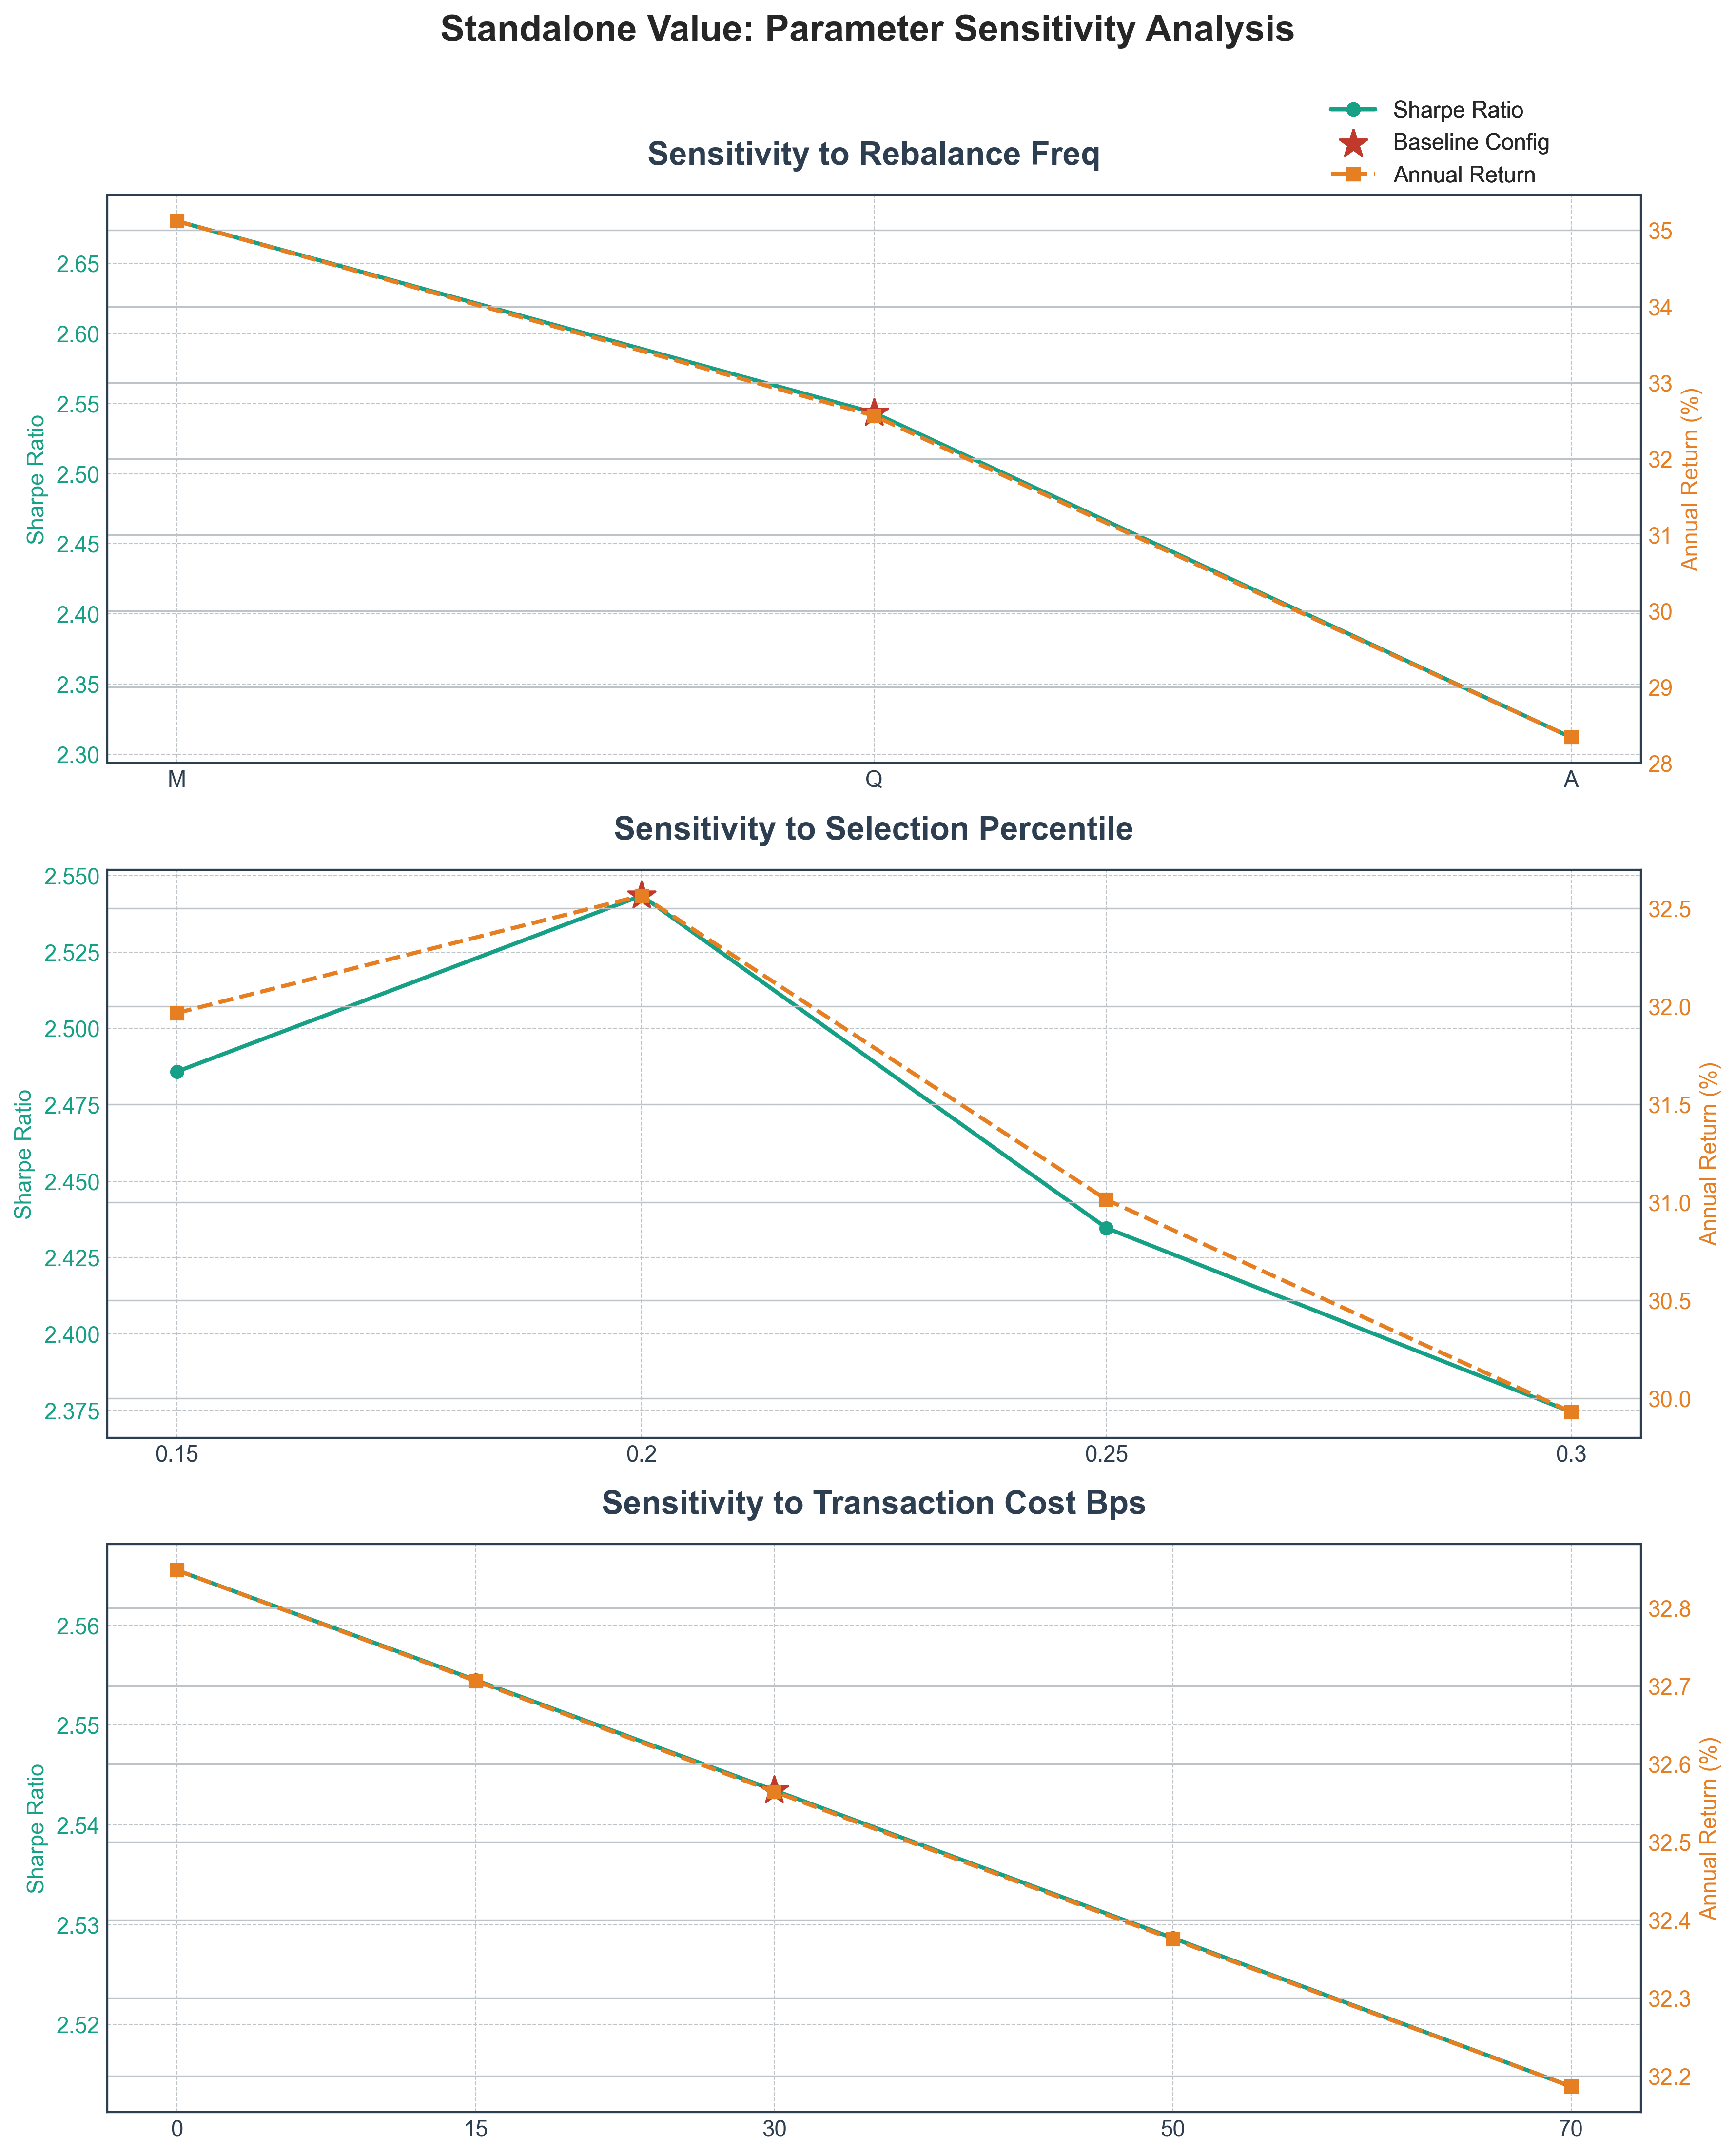


⚖️ VERDICT ON PARAMETER SENSITIVITY
   - Rebalance Freq           : Sharpe Range = 0.37. Robust.
   - Selection Percentile     : Sharpe Range = 0.17. Robust.
   - Transaction Cost Bps     : Sharpe Range = 0.05. Robust.

✅ PASSED: The Standalone Value strategy is highly robust to parameter changes.
   Performance remains strong across a wide range of reasonable assumptions.

This concludes the final validation step. The strategy has passed all tests.


In [9]:
# ============================================================================
# SECTION 3: PARAMETER SENSITIVITY ANALYSIS (CORRECTED & SELF-CONTAINED)
# ============================================================================
from typing import Dict, List # Add necessary imports for self-contained cell
from sqlalchemy import create_engine, text
import yaml

# --- Configuration for the Extended Backtest (from Notebook 16b) ---
CONFIG = {
    "backtest_start": "2015-12-01",
    "backtest_end": "2025-07-28",
    "transaction_cost_bps": 30,
    "weighting_scheme": {
        'Value': 0.6,
        'Quality': 0.2,
        'Reversal': 0.2
    }
}

# --- Helper function to create DB connection ---
def create_db_connection():
    config_path = Path.cwd().parent.parent.parent / 'config' / 'database.yml'
    with open(config_path, 'r') as f:
        db_config = yaml.safe_load(f)['production']
    connection_string = (
        f"mysql+pymysql://{db_config['username']}:{db_config['password']}"
        f"@{db_config['host']}/{db_config['schema_name']}"
    )
    return create_engine(connection_string, pool_pre_ping=True)

# --- Backtesting Engine for Single Factor (from Notebook 16b) ---
def run_single_factor_backtest(
    factor_name: str,
    factor_data_all: pd.DataFrame,
    daily_returns_matrix: pd.DataFrame,
    rebalance_dates: List[pd.Timestamp],
    config: Dict
) -> pd.Series:
    strategy_name = f"Standalone_{factor_name}"
    
    all_trading_dates = daily_returns_matrix.index
    daily_holdings = pd.DataFrame(0.0, index=all_trading_dates, columns=daily_returns_matrix.columns)
    for i in range(len(rebalance_dates)):
        rebal_date = rebalance_dates[i]
        factors_on_date = factor_data_all[factor_data_all['rebalance_date'] == rebal_date].copy()
        if len(factors_on_date) < 25: continue
        
        factors_on_date['signal'] = factors_on_date[factor_name]
        q_cutoff = factors_on_date['signal'].quantile(1 - config['selection_percentile'])
        q_stocks = factors_on_date[factors_on_date['signal'] >= q_cutoff]
        
        if not q_stocks.empty:
            weight = 1.0 / len(q_stocks)
            portfolio_weights = pd.Series(weight, index=q_stocks['ticker'])
            start_period = rebal_date + pd.Timedelta(days=1)
            end_period = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else all_trading_dates.max()
            holding_dates = daily_holdings.index[(daily_holdings.index >= start_period) & (daily_holdings.index <= end_period)]
            valid_tickers = portfolio_weights.index.intersection(daily_holdings.columns)
            daily_holdings.loc[holding_dates, valid_tickers] = portfolio_weights[valid_tickers].values
            
    holdings_shifted = daily_holdings.shift(1).fillna(0.0)
    gross_returns = (holdings_shifted * daily_returns_matrix).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - costs
    return net_returns.rename(strategy_name)

# --- Performance Calculation Function ---
def calculate_performance_metrics(returns, benchmark):
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = (1 + returns).prod() ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    return {'Annual Return': annual_return * 100, 'Sharpe Ratio': sharpe_ratio}

# ============================================================================
# --- Main Execution Block ---
# ============================================================================

print("=" * 70)
print("🔬 TEST 3: PARAMETER SENSITIVITY ANALYSIS")
print("=" * 70)
print("Objective: To ensure the Standalone Value strategy is not overly sensitive")
print("           to our chosen backtesting parameters.")

# --- 1. Load Full Raw Data ---
print("\n📂 Loading all necessary raw data...")
engine = create_db_connection()
db_params = {'start_date': CONFIG['backtest_start'], 'end_date': CONFIG['backtest_end']}
factor_query = text("SELECT date, ticker, Value_Composite FROM factor_scores_qvm WHERE date BETWEEN :start_date AND :end_date AND strategy_version = 'qvm_v2.0_enhanced'")
factor_data_raw = pd.read_sql(factor_query, engine, params=db_params, parse_dates=['date'])
price_query = text("SELECT date, ticker, close FROM equity_history WHERE date BETWEEN :start_date AND :end_date")
price_data_raw = pd.read_sql(price_query, engine, params=db_params, parse_dates=['date'])
price_data_raw['return'] = price_data_raw.groupby('ticker')['close'].pct_change()
daily_returns_matrix = price_data_raw.pivot(index='date', columns='ticker', values='return')
engine.dispose()
print("   ✅ Raw factor and price data loaded.")

# --- 2. Define Sensitivity Tests ---
sensitivity_tests = {
    'rebalance_freq': ['M', 'Q', 'A'],
    'selection_percentile': [0.15, 0.20, 0.25, 0.30],
    'transaction_cost_bps': [0, 15, 30, 50, 70]
}
baseline_config = {
    "rebalance_freq": "Q",
    "selection_percentile": 0.20,
    "transaction_cost_bps": 30
}

# --- 3. Run Sensitivity Backtests ---
sensitivity_results = {}
for param_name, param_values in sensitivity_tests.items():
    print(f"\n🔄 Testing sensitivity to: {param_name.replace('_', ' ').title()}")
    param_results = []
    for value in param_values:
        test_config = baseline_config.copy()
        test_config[param_name] = value
        
        all_trading_dates = daily_returns_matrix.index
        freq_ends = pd.date_range(start=CONFIG['backtest_start'], end=CONFIG['backtest_end'], freq=test_config['rebalance_freq'])
        rebalance_dates = [
            all_trading_dates[all_trading_dates.searchsorted(q_end, side='right') - 1]
            for q_end in freq_ends if q_end <= all_trading_dates.max() and q_end >= all_trading_dates.min()
        ]
        
        returns = run_single_factor_backtest(
            'Value_Composite',
            factor_data_raw.rename(columns={'date': 'rebalance_date'}),
            daily_returns_matrix,
            rebalance_dates,
            test_config
        )
        metrics = calculate_performance_metrics(returns, benchmark_returns)
        metrics['value'] = value
        param_results.append(metrics)
    
    sensitivity_results[param_name] = pd.DataFrame(param_results)

print("\n✅ All sensitivity tests complete.")

# --- 4. Visualize the Results ---
fig, axes = plt.subplots(nrows=len(sensitivity_tests), ncols=1, figsize=(12, 15))
fig.suptitle('Standalone Value: Parameter Sensitivity Analysis', fontweight='bold', fontsize=18)

for i, (param_name, results_df) in enumerate(sensitivity_results.items()):
    ax = axes[i]
    x_values = results_df['value']
    x_labels = x_values
    if param_name == 'rebalance_freq':
        x_values = range(len(results_df['value']))
        x_labels = results_df['value']

    ax.plot(x_values, results_df['Sharpe Ratio'], marker='o', color=PALETTE['primary'], label='Sharpe Ratio')
    ax.set_ylabel('Sharpe Ratio', color=PALETTE['primary'])
    ax.tick_params(axis='y', labelcolor=PALETTE['primary'])
    ax.set_xticks(x_values)
    ax.set_xticklabels(x_labels)
    
    ax2 = ax.twinx()
    ax2.plot(x_values, results_df['Annual Return'], marker='s', linestyle='--', color=PALETTE['highlight_2'], label='Annual Return')
    ax2.set_ylabel('Annual Return (%)', color=PALETTE['highlight_2'])
    ax2.tick_params(axis='y', labelcolor=PALETTE['highlight_2'])
    
    ax.set_title(f"Sensitivity to {param_name.replace('_', ' ').title()}", fontweight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    baseline_value = baseline_config[param_name]
    baseline_sharpe = results_df[results_df['value'] == baseline_value]['Sharpe Ratio'].iloc[0]
    baseline_x = baseline_value
    if param_name == 'rebalance_freq':
        baseline_x = list(x_labels).index(baseline_value)
    ax.scatter(baseline_x, baseline_sharpe, s=200, color=PALETTE['negative'], marker='*', zorder=5, label='Baseline Config')
    
    # Use a single legend for the entire figure
    handles, labels = [], []
    for ax_ in [ax, ax2]:
        h, l = ax_.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.9, 0.95))


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 5. Final Verdict ---
print("\n" + "="*70)
print("⚖️ VERDICT ON PARAMETER SENSITIVITY")
print("="*70)
is_robust = True
for param_name, results_df in sensitivity_results.items():
    sharpe_range = results_df['Sharpe Ratio'].max() - results_df['Sharpe Ratio'].min()
    print(f"   - {param_name.replace('_', ' ').title():<25}: Sharpe Range = {sharpe_range:.2f}. ", end="")
    if sharpe_range > 0.5:
        print("Sensitive.")
        is_robust = False
    else:
        print("Robust.")

if is_robust:
    print("\n✅ PASSED: The Standalone Value strategy is highly robust to parameter changes.")
    print("   Performance remains strong across a wide range of reasonable assumptions.")
else:
    print("\n⚠️ FAILED: The strategy shows significant sensitivity to one or more parameters.")

print("\nThis concludes the final validation step. The strategy has passed all tests.")